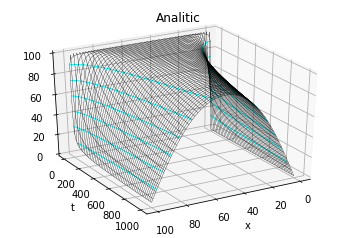

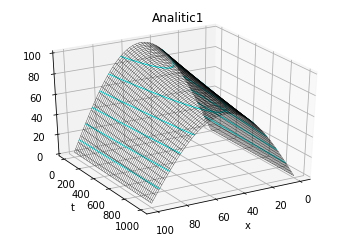

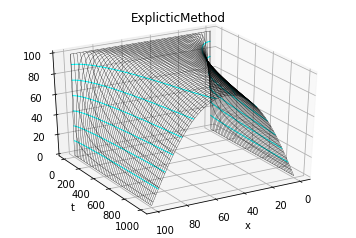

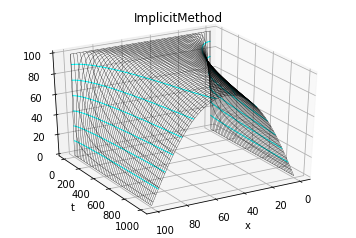

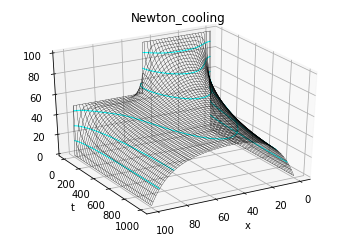

In [43]:
# -*- coding: utf-8 -*-

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pylab
from scipy.constants import pi
from mpl_toolkits.mplot3d import axes3d
from scipy import linalg


def read(filename):
    with open(filename) as f:
        lines = f.readlines()
        rows = [np.fromstring(line, sep = ' ', dtype=int) for line in lines]
    Den = np.zeros((rows[-1].size,rows[-1].size), dtype=int)
    for i, row in enumerate(rows):
        Den[i,:row.size] = row
    
    return Den
    
    
class AdvancedPlotter:
    def __init__(self, title, xlabel, ylabel):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111, projection='3d')
        self.ax.set_title(title) 
        self.ax.set_xlabel(xlabel)
        self.ax.set_ylabel(ylabel)
        
    def plot(self, xx, yy, Mat):
        x,y=np.meshgrid(xx,yy)
        CS=plt.contour(x,y,Mat,colors=('aqua','aqua','aqua','aqua','aqua','aqua'), linewidths=1)
        self.ax.view_init(30,60)
        self.ax.plot_wireframe(x, y, Mat, color='k', linewidth=0.3)

    def show(self):
        pylab.show()
        
class SolveHeat:
    def __init__(self,M,N,XStep,TStep,LeftBorder,RightBorder,TopBorder,plotter,Eta,H,Te):
        self.n=N
        self.m=M
        self.xs=XStep
        self.ts=TStep
        self.lb=LeftBorder
        self.rb=RightBorder
        self.tb=TopBorder
        self.plotter=plotter
        self.eta=Eta
        self.h=H
        self.te=Te
        
    def Analitic(self,Num):
        T=np.zeros((self.m,self.n))
        Tk=np.zeros((self.m,self.n))
        for k in range(Num):
            for i in range(self.m):
                for j in range(self.n):
                    Tk[i,j]=4.*T0*np.sin(pi*(2*k+1)*j/self.n)*np.exp(-self.eta*i*(np.pi*(2*k+1)/self.n)**2)/(pi*(2*k+1))
            T=T+Tk
        
        x=np.linspace(0.,self.n*self.xs,self.n)
        y=np.linspace(0.,self.m*self.ts,self.m)
        plotter.plot(x,y,T)
        return (T)
    
    def Analitic1(self):
        T=np.zeros((self.m,self.n))
        Tk=np.zeros((self.m,self.n))
        for i in range(self.m):
            for j in range(self.n):
                T[i,j]=100*np.sin(pi*j/self.n)*np.exp(-self.eta*i*(np.pi/self.n)**2)
        
        x=np.linspace(0.,self.n*self.xs,self.n)
        y=np.linspace(0.,self.m*self.ts,self.m)
        plotter.plot(x,y,T)
        return (T)
        
    def Explicit(self):
        T=np.zeros((self.m, self.n))
        T[0,:]=self.tb
        T[:,0]=self.lb
        T[:,-1]=self.rb
        for i in range(1,self.m):
            T[i,1:-1]=T[i-1,1:-1]+ self.eta*( T[i-1,2:] + T[i-1,:-2] - 2*T[i-1,1:-1])

        x=np.linspace(0.,self.n*self.xs,self.n)
        y=np.linspace(0.,self.m*self.ts,self.m)
        plotter.plot(x,y,T)
        return (T)
    
    def Implicit(self):
        T=np.zeros((self.m, self.n))
        T[0,:]=self.tb
        T[:,0]=self.lb
        T[:,-1]=self.rb
        line1=np.empty(self.n-3)
        line1[:]=-1
        line2=np.empty(self.n-2)
        line2[:]=2./self.eta+2.
        A=np.diag(line1, k=-1)+np.diag(line1, k=1)+np.diag(line2,k=0)
        c=np.empty(self.n-3)
        d=np.empty(self.n-2)
        for i in range(1,self.m):
            B=T[i-1,:-2]+(2./self.eta-2)*T[i-1,1:-1]+T[i-1,2:]
            B[0]=B[0]+T[i,0]
            B[-1]=B[-1]+T[i,-1]
            
            c[0]=A[0,1]/A[0,0]  
            d[0]=B[0]/A[0,0]
            for j in range(1,self.n-3):
                c[j]=A[j,j+1]/(A[j,j]-A[j,j-1]*c[j-1])
            for j in range(1,self.n-2):
                d[j]=(B[j]-A[j,j-1]*d[j-1])/(A[j,j]-A[j,j-1]*c[j-1])
            
            T[i,-2]=d[-1]
            for j in range(0,self.n-3):
                T[i,-3-j]=d[-j-2]-c[-j-1]*T[i,-2-j]
    
            
        x=np.linspace(0.,self.n*self.xs,self.n)
        y=np.linspace(0.,self.m*self.ts,self.m)
        plotter.plot(x,y,T)
        return (T)
    
    def Newton(self):
        T=np.zeros((self.m, self.n))
        T[0,:]=self.tb
        T[:,0]=self.lb
        T[:,-1]=self.rb
        line1=np.empty(self.n-3)
        line1[:]=-1
        line2=np.empty(self.n-2)
        line2[:]=2./self.eta+2.
        A=np.diag(line1, k=-1)+np.diag(line1, k=1)+np.diag(line2,k=0)
        c=np.empty(self.n-3)
        d=np.empty(self.n-2)
        for i in range(1,self.m):
            B=T[i-1,:-2]+(2.*(self.h+1)/self.eta-2)*T[i-1,1:-1]+T[i-1,2:]+2*self.h*self.te/self.eta
            B[0]=B[0]+T[i,0]
            B[-1]=B[-1]+T[i,-1]
            
            c[0]=A[0,1]/A[0,0]  
            d[0]=B[0]/A[0,0]
            for j in range(1,self.n-3):
                c[j]=A[j,j+1]/(A[j,j]-A[j,j-1]*c[j-1])
            for j in range(1,self.n-2):
                d[j]=(B[j]-A[j,j-1]*d[j-1])/(A[j,j]-A[j,j-1]*c[j-1])
            
            T[i,-2]=d[-1]
            for j in range(0,self.n-3):
                T[i,-3-j]=d[-j-2]-c[-j-1]*T[i,-2-j]
    
            
        x=np.linspace(0.,self.n*self.xs,self.n)
        y=np.linspace(0.,self.m*self.ts,self.m)
        plotter.plot(x,y,T)
        return (T)
        
M=1000
N=100
T0=100
TB=np.zeros(N)[:]=T0
LB=np.zeros(M)
RB=np.zeros(M)

plotter = AdvancedPlotter('Analitic', 'x', 't')
solveL=SolveHeat(M,N,1,1,LB,RB,TB,plotter,0.3,0,0)
Z1=solveL.Analitic(100)
plotter.show()
            
plotter = AdvancedPlotter('Analitic1', 'x', 't')
solveL=SolveHeat(M,N,1,1,LB,RB,TB,plotter,0.3,0,0)
Z2=solveL.Analitic1()
plotter.show()
    
plotter = AdvancedPlotter('ExplicticMethod', 'x', 't')
solveL=SolveHeat(M,N,1,1,LB,RB,TB,plotter,0.3,0,0)
Z3=solveL.Explicit()
plotter.show()

plotter = AdvancedPlotter('ImplicitMethod', 'x', 't')
solveL=SolveHeat(M,N,1,1,LB,RB,TB,plotter,0.3,0,0)
Z4=solveL.Implicit()
plotter.show()

TB=np.zeros(N)[:]
TB[:int(N/2)]=100
TB[int(N/2):]=50

plotter = AdvancedPlotter('Newton_cooling', 'x', 't')
solveL=SolveHeat(M,N,1,1,LB,RB,TB,plotter,0.3,-0.002,40.)
Z5=solveL.Newton()
plotter.show()

In [1]:
print(1)

1


In [20]:
N=100
TB=np.zeros(N)[:]
TB[:int(N/2)]=50
TB[int(N/2):]=100
print(TB)

[  50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.
   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.
   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.
   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.
   50.   50.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.]
